# Diagnostic Workflow of `moirae`

In this notebook, we demonstrate how to use `moirae` tools to set up a diagnostic workflow.

## Generating Data

First, we need to figure out what data to use. For now, we will generate data using the `esynthm` package, but, if you do not have access to it, please jump down to the next section, on Offline Estimation. 

First, we need to decide on an aSOH for the simulation. We will try to somewhat mimic a LFP cell:
- Relatively flat OCV 
- High degree of SOC-dependent dynamic hysteresis
- SOC-depended series resistance
- Two RC-pairs, one corresponding to an ~15 minute relaxation time, and one for ~1 minute.

We will also employ a total capacity of 10 Amp-hour, and a Coulombic efficiency of 99.8%.

In [1]:
import numpy as np

from moirae.models.components.soc import SOCInterpolatedHealth
from moirae.models.ecm.components import (MaxTheoreticalCapacity,
                                          Resistance,
                                          Capacitance,
                                          RCComponent,
                                          OpenCircuitVoltage,
                                          HysteresisParameters)
from moirae.models.ecm.advancedSOH import ECMASOH

# Capacity
capacity_gt = MaxTheoreticalCapacity(base_values=10)

# OCV
reference_ocv = SOCInterpolatedHealth(base_values=[2.35, 3.0, 3.2, 3.25, 3.28, 3.3, 3.31, 3.32, 3.34, 3.35, 3.6],
                                      soc_pinpoints=[0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.65, 0.7, 0.75, 0.975, 1.0])
ocv_gt = OpenCircuitVoltage(ocv_ref=reference_ocv)

# Hysteresis
hyst_gt = HysteresisParameters(base_values=[0.07, 0.035, 0.035, 0.02, 0.02, 0.01, 0.01],
                               soc_pinpoints=[0.0, 0.1, 0.3, 0.4, 0.6, 0.7, 1.0])

# Series resistance
r0_gt = Resistance(base_values=1.0e-03 * np.array([6., 4., 5.]), interpolation_style='quadratic')

# RC Pairs
# RC 1: 1 minute relaxation time, SOC-independent parameters
r_rc_1_gt = Resistance(base_values=2.0e-03)
c_rc_1_gt = Capacitance(base_values=3.0e+04)
rc_1_gt = RCComponent(r=r_rc_1_gt, c=c_rc_1_gt)
# RC 2: ~30 minute relaxation time, linear SOC dependence
taus_2_gt = 60 * np.array([12., 15., 18.])  # ~15 minute relaxation time
r_rc_2_base_vals_gt = 1.0e-04 * np.array([8., 9., 10.])
c_rc_2_base_vals_gt = taus_2_gt / r_rc_2_base_vals_gt
r_rc_2_gt = Resistance(base_values=r_rc_2_base_vals_gt)
c_rc_2_gt = Capacitance(base_values=c_rc_2_base_vals_gt)
rc_2_gt = RCComponent(r=r_rc_2_gt, c=c_rc_2_gt)

# Assemble aSOH
asoh_gt = ECMASOH(q_t=capacity_gt,
                  ce=0.998,
                  ocv=ocv_gt,
                  h0=hyst_gt,
                  r0=r0_gt,
                  rc_elements=[rc_1_gt, rc_2_gt]
                  )

Now, let's specify some details about the cycling of the cell. We will stick to standard CC/CV protocols, using the following specifications:
- We will use voltage limits corresponding to 0 and 100% SOC
- Charging is done with a CCCV protocol, and will occur at C-rates chosen randomly (uniformly) between 0.5 and 2.0.
- Discharge will happen at C-rates chosen randomly (uniformly) between 0.25 and 5. With 20% chance, discharge will be a pure CC protocol, but with 80% chance, it will be CCCV

In [2]:
from esynthm.protocol_pickers.standard import (RandomizedStandardProtocolPicker,
                                               CRateRanges,
                                               StandardCyclingOptions)
from esynthm.protocol_pickers.standard.options import SingleStageOptions

# Choose a random seed for reproducibility
rng_seed = 2025

# Specify voltage limits
voltage_limits = tuple(asoh_gt.ocv(soc=[0.0, 1.0]).flatten().tolist())

# Specify charge/discharge protocols
chg_prot = SingleStageOptions(labels=['CCCV'])
dischg_prot = SingleStageOptions(labels=['CC', 'CCCV'],
                                 probabilities=[20, 80])
protocols = StandardCyclingOptions(charge=chg_prot, discharge=dischg_prot)

# Specify C-rates
c_rates = CRateRanges(charge=(0.5, 2.0), discharge=(0.25, 5.0))

protocol_picker = RandomizedStandardProtocolPicker(voltage_limits=voltage_limits,
                                                   c_rate_ranges=c_rates,
                                                   cycling_protocols=protocols,
                                                   first_step='charge',
                                                   rng_seed=rng_seed)

When cycling, RPTs can also be conducted periodically. Here, we will choose to perform a full RPT (that is, HPPC test and a capacity check low-rate cycle) at every 250 cycles, for demonstration purposes.

In [3]:
from esynthm import RPTFrequency,SpecialCycleFrequency, DiagnosticParameters

rpt_freq = RPTFrequency(full=SpecialCycleFrequency(cycles=750))
diagnostic = DiagnosticParameters(rpt_frequency=rpt_freq)

We will start the cell at 50% SOC.

In [4]:
from moirae.models.ecm.transient import ECMTransientVector

# Prepare initial transient state
transient0 = ECMTransientVector.from_asoh(asoh=asoh_gt)
transient0.soc = np.atleast_2d(0.5)

For checkpointing purposes, let's save the results every 200 cycles.

In [5]:
import os

# Save file
save_file = 'data/workflow_demo.h5'

In [ ]:
# Preparing saving options
if os.path.isfile(save_file):  # delete file if it already exists, as we do not want to append to it
    os.unlink(save_file)

saving_options={'file_path': save_file, 'cycle_frequency': 200}

Now, we will initialize the orchestrator. For simplicity, we will use no degradation of the cell, and will conduct no rapid RPTs. We will also only save the results at the end of the run

In [7]:
from esynthm import CyclingOrchestrator

orchestrator = CyclingOrchestrator(protocol_picker=protocol_picker,
                                   starting_asoh=asoh_gt,
                                   starting_transient=transient0,
                                   diagnostic_params=diagnostic,
                                   saving_options=saving_options,
                                   rng_seed=rng_seed)

/Users/vventuri/Library/CloudStorage/Dropbox/Argonne/Code/ecm-synthetic-data-gen/esynthm/__init__.py:117: UserWarning: The orchestrator will not degrade the cell!
  warnings.warn('The orchestrator will not degrade the cell!')
/Users/vventuri/Library/CloudStorage/Dropbox/Argonne/Code/ecm-synthetic-data-gen/esynthm/__init__.py:275: UserWarning: Using automatically generated metadata!
  warnings.warn('Using automatically generated metadata!')


Finally, let's run the cell for 1000 cycles! (<mark>Note:</mark> this takes about 8 minutes)

In [8]:
orchestrator.run_cycles(num_cycles=1000, save_to_file=True)

 20%|█▉        | 198/1000 [01:29<05:32,  2.41it/s]

Saving cycles 1 -- 200 to data/workflow_demo.h5


 40%|███▉      | 398/1000 [03:00<04:03,  2.47it/s]

Saving cycles 201 -- 400 to data/workflow_demo.h5


 60%|█████▉    | 598/1000 [04:32<02:50,  2.36it/s]

Saving cycles 401 -- 600 to data/workflow_demo.h5


 80%|███████▉  | 797/1000 [06:06<01:25,  2.38it/s]

Saving cycles 601 -- 800 to data/workflow_demo.h5


100%|█████████▉| 997/1000 [07:34<00:01,  2.47it/s]

Saving cycles 801 -- 1000 to data/workflow_demo.h5


100%|██████████| 1000/1000 [07:40<00:00,  2.17it/s]

Saving cycles 1001 -- 1002 to data/workflow_demo.h5


## Offline Estimation

Here, we will read the data back in, and use `moirae`'s offline estimation tools to estimate the aSOH of the cell from the first RPT cycles conducted. 

### Data visualization

Start by reading the data back in (<mark>Note</mark>: if you don't have `esynthm` installed, start from the cell below, but keep in mind you might need to import some of the packages from previous cells)

In [6]:
from battdat.data import BatteryDataset

simulated_dataset = BatteryDataset.from_hdf(path_or_buf=save_file)
raw_data = simulated_dataset.tables.get('raw_data')

v_min, v_max = raw_data['voltage'].min(), raw_data['voltage'].max()
print(f'Volage range: {v_min:.1f} -- {v_max:.1f} V')

Volage range: 2.2 -- 3.6 V


Before we more on, let us briefly visualize the data, starting with the initial RPT.

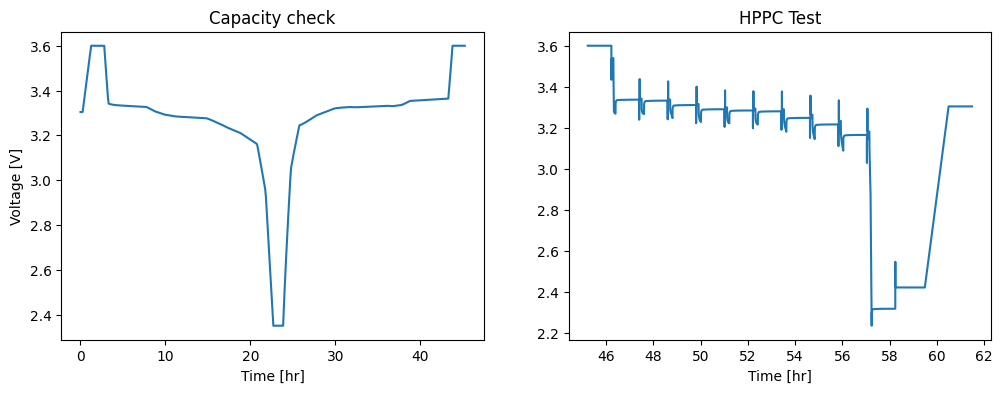

In [7]:
import matplotlib.pyplot as plt

initial_rpt = raw_data[raw_data['cycle_number'] <= 2]
capacity_check = initial_rpt[initial_rpt['protocol'] == 'Capacity Check']
hppc = initial_rpt[initial_rpt['protocol'] == 'Full HPPC']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].set_ylabel('Voltage [V]')
# Capacity check
axes[0].set_xlabel('Time [hr]')
axes[0].set_title('Capacity check')
axes[0].plot(capacity_check['test_time'] / 3600, capacity_check['voltage'])
# Capacity check
axes[1].set_xlabel('Time [hr]')
axes[1].set_title('HPPC Test')
axes[1].plot(hppc['test_time'] / 3600, hppc['voltage'])

Now, let's choose a range of cycles and plot those.

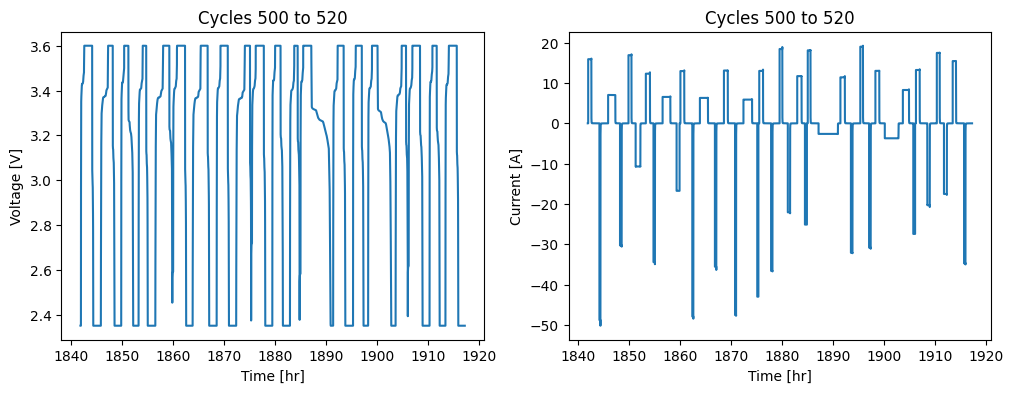

In [8]:
min_cycle = 500
max_cycle = 520

cycle_numbers_chosen = range(min_cycle, max_cycle)
cycles_chosen = raw_data[raw_data['cycle_number'].isin(cycle_numbers_chosen)]

fig, axes = plt.subplots(1, 2, figsize=((12, 4)))
# Voltage
axes[0].set_ylabel('Voltage [V]')
axes[0].set_xlabel('Time [hr]')
axes[0].set_title(f'Cycles {min_cycle} to {max_cycle}')
axes[0].plot(cycles_chosen['test_time'] / 3600, cycles_chosen['voltage'])
# Current
axes[1].set_ylabel('Current [A]')
axes[1].set_xlabel('Time [hr]')
axes[1].set_title(f'Cycles {min_cycle} to {max_cycle}')
axes[1].plot(cycles_chosen['test_time'] / 3600, cycles_chosen['current'])

### Step-by-step

In order to estimate the aSOH from the RPT data, we should evaluate it step by step.

#### Capacity and Coulombic efficiency

The first things we should estimate from the RPT are the cell maximum discharge capacity and its coulombic efficiency, which can be extracted from the capacity check test. We will use `moirae`'s extractor to do this, and take the results of that and give it to an assembler, to create the capacity object.

In [9]:
from moirae.estimators.offline.extractors.ecm import MaxCapacityCoulEffExtractor
from moirae.estimators.offline.assemblers.ecm import CapacityAssembler

# Initialize extractor
extractor = MaxCapacityCoulEffExtractor()

# Get extracted values
max_cap_info, ce_info = extractor.extract(data=capacity_check)

# Assemble capacity object
capacity_assembled = CapacityAssembler().assemble(extracted_parameter=max_cap_info)
ce_extracted = ce_info['value']

# Compare the results
print('Capacity:')
print(f'\tGround truth = {capacity_gt.amp_hour.item():.1f} Amp-hour')
print(f'\tExtracted = {capacity_assembled.amp_hour.item():.2f} Amp-hour')
print('=' * 50)
print('Coulombic efficiency:')
print(f'\tGround truth = {100 * asoh_gt.ce.item():.3f} %')
print(f'\tExtracted = {100 * ce_extracted:.3f} %')

Capacity:
	Ground truth = 10.0 Amp-hour
	Extracted = 9.94 Amp-hour
Coulombic efficiency:
	Ground truth = 99.800 %
	Extracted = 99.790 %


#### Series Resistance

With the capacity information at hand, we can extract the series resistance.

Remember to use the extracted capacity and extracted Coulombic efficiency, rather than the ground truth ones!

In [10]:
from moirae.estimators.offline.extractors.ecm import R0Extractor

r0_extractor = R0Extractor.init_from_basics(
    capacity=capacity_assembled,
    coulombic_efficiency=ce_extracted,
    min_delta_soc=0.95,  # ensure at least 95% of the SOC range is covered
    min_pulses=10,  # at least 10 pulses must be present in HPPC
    ensure_bidirectional=True,  # makes sure they are for the most part bidirectional, except for at 0 and 100% SOC
    dcurr_min=0.1  # minnimum current difference at which we extract the R0 value
)

# Let's "cheat" a bit and use the true SOC at the beginning of the HPPC, which should not be difficult to obtain
hppc_start_soc = hppc['SOC'].iloc[0]

r0_extracted = r0_extractor.extract(data=hppc, start_soc=hppc_start_soc)

Now, let us plot these against the ground truth, and see how they compared.

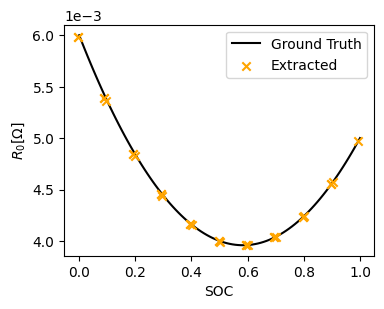

In [11]:
soc_plot = np.linspace(0., 1., 100)

fig, axes = plt.subplots(figsize=(4, 3))
axes.set_xlabel('SOC')
axes.set_ylabel(r'$R_0 [\Omega]$')
axes.ticklabel_format(axis='y', scilimits=(0, 0))
axes.plot(soc_plot, r0_gt.get_value(soc=soc_plot).flatten(),
          color='k', zorder=0,
          label='Ground Truth')
axes.scatter(r0_extracted['soc_level'], r0_extracted['value'],
             color='orange', marker='x', zorder=1,
             label='Extracted')
_ = axes.legend()

Now, recall that the assembled resistance follows a linear interpolation, so we will plot it again after assembling it to make sure it makes sense. Given the plot above, it is clear the profile is parabolic, so we can fit a degree-2 polynomial through the points.

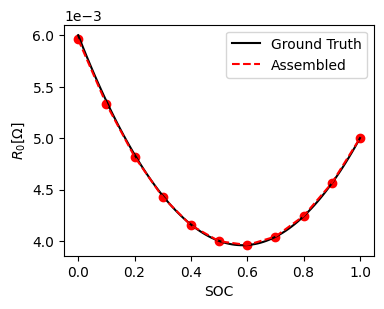

In [12]:
from moirae.estimators.offline.assemblers.utils import SOCRegressor
from moirae.estimators.offline.assemblers.ecm import ResistanceAssembler

# Regressor
# r0_regressor = SOCRegressor(style='interpolate', parameters={'k': 0})
r0_regressor = SOCRegressor(style='polyfit', parameters={'deg': 2})

# Assembler
r0_assembler = ResistanceAssembler(regressor=r0_regressor,
                                   soc_points=np.linspace(0., 1., 11))
# Assemble
r0_assembled = r0_assembler.assemble(extracted_parameter=r0_extracted)

# Plot
fig, axes = plt.subplots(figsize=(4, 3))
axes.set_xlabel('SOC')
axes.set_ylabel(r'$R_0 [\Omega]$')
axes.ticklabel_format(axis='y', scilimits=(0, 0))
axes.plot(soc_plot, r0_gt.get_value(soc=soc_plot).flatten(),
          color='k',
          label='Ground Truth')
axes.scatter(r0_assembled.soc_pinpoints.flatten(), r0_assembled.base_values.flatten(),
             marker='o', color='r')
axes.plot(soc_plot, r0_assembled.get_value(soc=soc_plot).flatten(),
             color='red', linestyle='--',
             label='Assembled')
_ = axes.legend()

#### RC components

Let's also take a look at the RC components, since we don't need any more than just capacity and Coulombic efficiency for that.

Once again, start by extracting the data first.

In [13]:
from moirae.estimators.offline.extractors.ecm import RCExtractor

# Initialize extractor
rc_extractor = RCExtractor.init_from_basics(
    capacity=capacity_assembled,
    coulombic_efficiency=ce_extracted,
    min_delta_soc=0.95,  # ensure at least 95% of the SOC range is covered
    min_number_of_rests=10,  # ensure there are at least 10 rests to be used
    min_rest_duration=900,  # ensure each rest lasts at least 15 min
    min_prev_duration=300.  # ensure the step prior to the rest lasts at least 5 min
    )

rc_extracted = rc_extractor.extract(data=hppc, n_rc=2, start_soc=hppc_start_soc)

Now, let us plot the extracted value to evaluate the best way of fitting them.

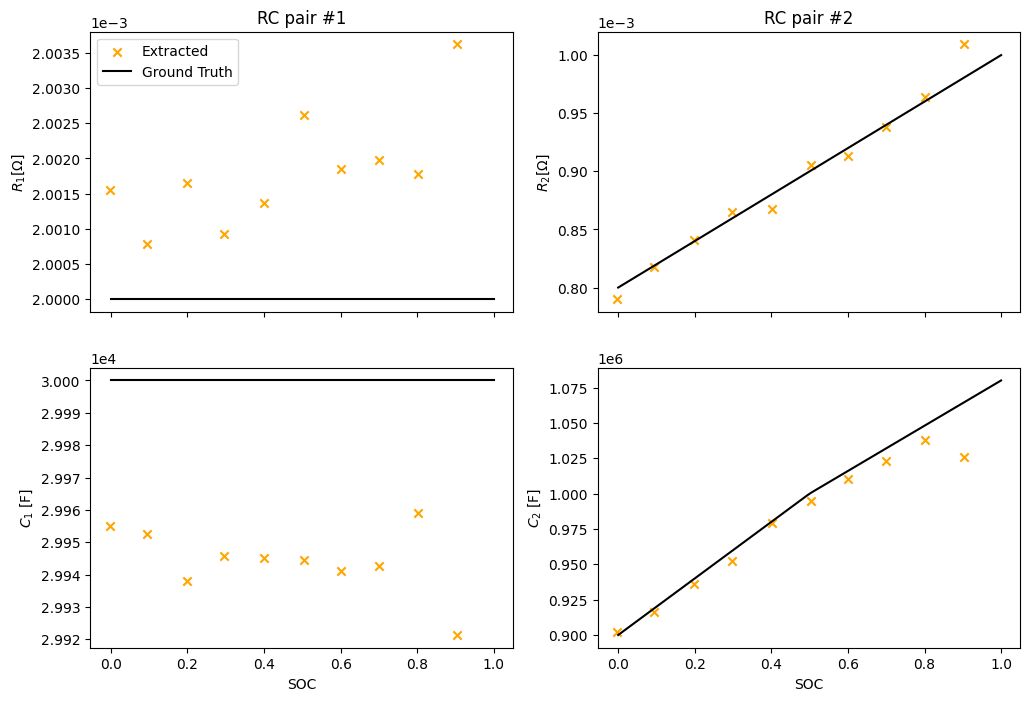

In [14]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(12, 8))
axes[-1, 0].set_xlabel('SOC')
axes[-1, 1].set_xlabel('SOC')

for i, (rc_ext, rc_gt) in enumerate(zip(rc_extracted, asoh_gt.rc_elements)):
    for j in [0, 1]:
        axes[j, i].ticklabel_format(axis='y', scilimits=(0, 0))
        axes[j, i].scatter(rc_ext[j]['soc_level'], rc_ext[j]['value'],
                        marker='x', color='orange',
                        label='Extracted')
    axes[0, i].set_title(f'RC pair #{i+1}')
    # Resistance
    axes[0, i].set_ylabel(fr'$R_{i+1} [\Omega]$')
    axes[0, i].plot(soc_plot, rc_gt.r.get_value(soc=soc_plot).flatten(),
                    color='k',
                    label='Ground Truth')
    # Capacitance
    axes[1, i].set_ylabel(fr'$C_{i+1}$ [F]')
    axes[1, i].plot(soc_plot, rc_gt.c.get_value(soc=soc_plot).flatten(),
                    color='k',
                    label='Ground Truth')

_ = axes[0, 0].legend()
    

While it is clear that the values are not exact, the discrepancy between them and the ground truth values is relatively small, in most cases corresponding to less than 5% of the value of the parameter. 

Looking only at the extracted values (red crosses), it makes sense to use the following forms of regressions:
- Both $R_1$ and $C_1$ appear to be constant; an LSQ between points slightly outside the SOC range shoud be able to acount for that
- $R_2$ seems to follow a linear trend; we could use a linear fit, but, for the sake of demonstration, let's use the interpolate functionality 
- $C_2$ looks like an inverted hump; perhaps a smoother can also handle that.

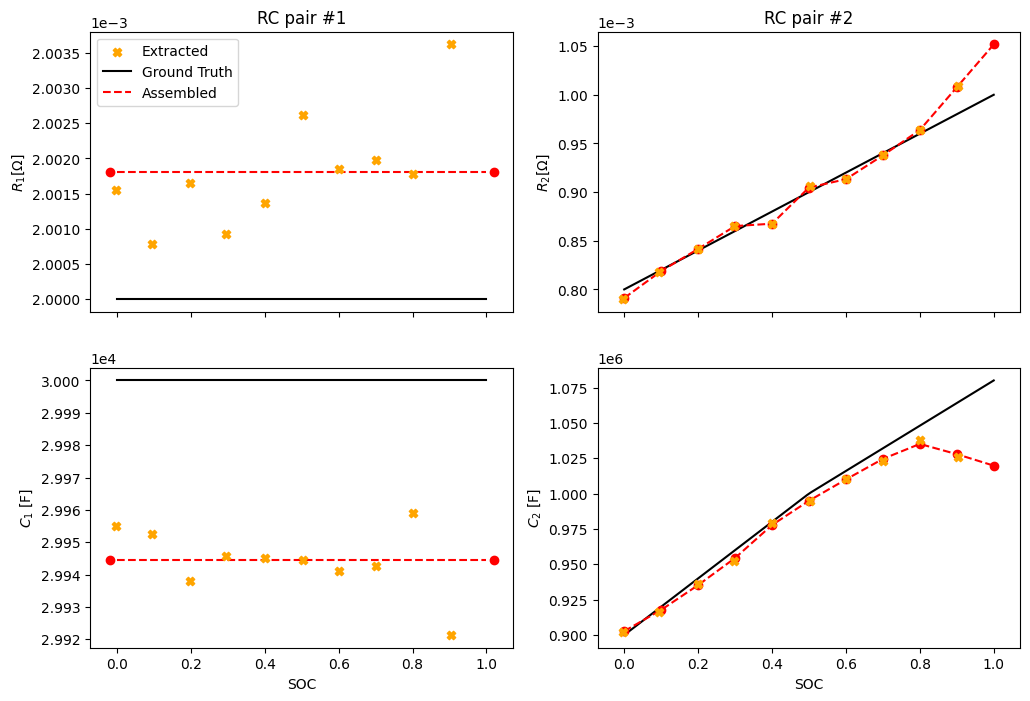

In [15]:
from moirae.estimators.offline.assemblers.ecm import CapacitanceAssembler

# Prepare regressors
r_1_regressor = SOCRegressor(style='lsq', parameters={'k': 0})
r_2_regressor = SOCRegressor(style='interpolate', parameters={'k': 1})
c_1_regressor = SOCRegressor(style='lsq', parameters={'k': 0})
c_2_regressor = SOCRegressor(style='smooth')

# Prepare assemblers
r_1_assembler = ResistanceAssembler(regressor=r_1_regressor, soc_points=np.array([-0.02, 1.02]))
r_2_assembler = ResistanceAssembler(regressor=r_2_regressor)
c_1_assembler = CapacitanceAssembler(regressor=c_1_regressor, soc_points=np.array([-0.02, 1.02]))
c_2_assembler = CapacitanceAssembler(regressor=c_2_regressor)
rc_assemblers = [(r_1_assembler, c_1_assembler), (r_2_assembler, c_2_assembler)]

# Prepare list to hold RC pairs
rc_assembled = []

for i, ((extracted_r, extracted_c), (r_assembler, c_assembler)) in enumerate(zip(rc_extracted, rc_assemblers)):
    resistance = r_assembler.assemble(extracted_parameter=extracted_r)
    capacitance = c_assembler.assemble(extracted_parameter=extracted_c)
    rc = RCComponent(r=resistance, c=capacitance)
    rc_assembled.append(rc)

fig, axes = plt.subplots(2, 2, sharex=True, figsize=(12, 8))
axes[-1, 0].set_xlabel('SOC')
axes[-1, 1].set_xlabel('SOC')

for i, (rc_ass, rc_gt) in enumerate(zip(rc_assembled, asoh_gt.rc_elements)):
    axes[0, i].set_title(f'RC pair #{i+1}')
    for j in [0, 1]:
        axes[j, i].ticklabel_format(axis='y', scilimits=(0, 0))
        axes[j, i].scatter(rc_extracted[i][j]['soc_level'], rc_extracted[i][j]['value'],
                        marker='X', color='orange', zorder=3,
                        label='Extracted')
    # Resistance
    axes[0, i].set_ylabel(fr'$R_{i+1} [\Omega]$')
    axes[0, i].plot(soc_plot, rc_gt.r.get_value(soc=soc_plot).flatten(),
                    color='k', zorder=0,
                    label='Ground Truth')
    axes[0, i].plot(soc_plot, rc_ass.r.get_value(soc=soc_plot).flatten(),
                    color='red', linestyle='--', zorder=1,
                    label='Assembled')
    axes[0, i].scatter(rc_ass.r.soc_pinpoints.flatten(), rc_ass.r.base_values.flatten(),
                       color='red', marker='o', zorder=2)
    # Capacitance
    axes[1, i].set_ylabel(fr'$C_{i+1}$ [F]')
    axes[1, i].plot(soc_plot, rc_gt.c.get_value(soc=soc_plot).flatten(),
                    color='k', zorder=0,
                    label='Ground Truth')
    axes[1, i].plot(soc_plot, rc_ass.c.get_value(soc=soc_plot).flatten(),
                    color='red', linestyle='--', zorder=1,
                    label='Assembled')
    axes[1, i].scatter(rc_ass.c.soc_pinpoints.flatten(), rc_ass.c.base_values.flatten(),
                       color='red', marker='o', zorder=2)

_ = axes[0, 0].legend()

#### Open Circuit Voltage (OCV)

Having knowledge of $Q_t$, Coulombic efficiency, and $R_0$, we can extract the OCV from the slow-rate capacity check cycle.

Start by extracting the OCV.

In [16]:
from moirae.estimators.offline.extractors.ecm import OCVExtractor

ocv_extractor = OCVExtractor.init_from_basics(capacity=capacity_assembled,
                                              coulombic_efficiency=ce_extracted,
                                              series_resistance=r0_assembled)

# Use the true SOC at the capacity check
cap_check_start_soc = capacity_check['SOC'].iloc[0]

ocv_extracted = ocv_extractor.extract(data=capacity_check, start_soc=cap_check_start_soc)

Now, let's plot this to have a better understanding of what we are dealing with.

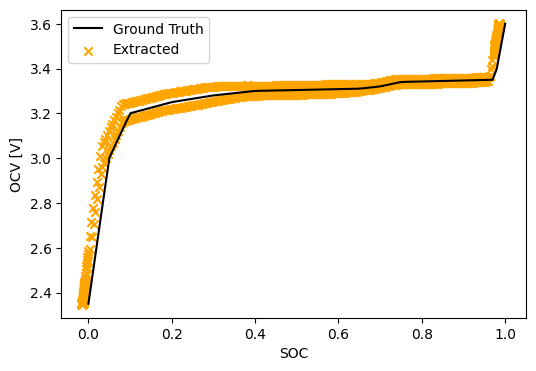

In [17]:
fig, axes = plt.subplots(figsize=(6, 4))
axes.set_xlabel('SOC')
axes.set_ylabel('OCV [V]')
axes.plot(soc_plot, ocv_gt(soc=soc_plot).flatten(),
          color='k', zorder=1,
          label='Ground Truth')
axes.scatter(ocv_extracted['soc_level'], ocv_extracted['value'],
             marker='x', color='orange', zorder=0,
             label='Extracted')
_ = axes.legend()

As we can see, there is a good degree of mismatch at low SOCs, likely due to the high values of hysteresis in that region. Notably, during the majority of the SOC domain, the extracted values do a good job of capturing the behavior. 

Based on the extracted values, it appears the OCV would be adequately characterized by values at SOCs of 0, 5, 10, 40, 70, 95, and 100%. We should also include a slightly negative value to properly capture the quick ramp up from 0 to 10% SOC.

In [18]:
from moirae.estimators.offline.assemblers.ecm import OCVAssembler

ocv_assembler = OCVAssembler(soc_points=np.array([0., 0.05, 0.1, 0.4, 0.7, 0.96, 1.]))
ocv_assembled = ocv_assembler.assemble(extracted_parameter=ocv_extracted)

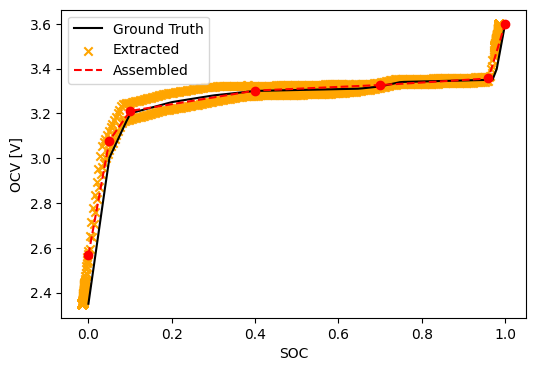

In [19]:
fig, axes = plt.subplots(figsize=(6, 4))
axes.set_xlabel('SOC')
axes.set_ylabel('OCV [V]')
axes.plot(soc_plot, ocv_gt(soc=soc_plot).flatten(),
          color='k', zorder=1,
          label='Ground Truth')
axes.scatter(ocv_extracted['soc_level'], ocv_extracted['value'],
             marker='x', color='orange', zorder=0,
             label='Extracted')
axes.plot(soc_plot, ocv_assembled(soc=soc_plot).flatten(),
          color='red', linestyle='--', zorder=2,
          label='Assembled')
axes.scatter(ocv_assembled.ocv_ref.soc_pinpoints.flatten(), ocv_assembled.ocv_ref.base_values.flatten(),
             color='red', marker='o')
_ = axes.legend()

#### Hysteresis

With the extracted parameters from the previous sections, we can now extract the hysteresis. Notably, hysteresis extraction can be pretty sensitive to the previous assembled parameters: here, we will extract it in two ways:
1. using the previously extracted and assembled parameters ("pure" extraction)
2. using the corresponding ground truth parameters

In [20]:
from moirae.estimators.offline.extractors.ecm import HysteresisExtractor

# From previous extractions
h0_extractor = HysteresisExtractor.init_from_basics(capacity=capacity_assembled,
                                                    coulombic_efficiency=ce_extracted,
                                                    ocv=ocv_assembled,
                                                    series_resistance=r0_assembled,
                                                    rc_elements=rc_assembled)
h0_extracted = h0_extractor.extract(data=capacity_check, start_soc=cap_check_start_soc)

# From GT parameters
gt_h0_extractor = HysteresisExtractor.init_from_basics(capacity=capacity_gt,
                                                       coulombic_efficiency=asoh_gt.ce.item(),
                                                       ocv=ocv_gt,
                                                       series_resistance=r0_gt,
                                                       rc_elements=asoh_gt.rc_elements)
gt_h0_extracted = gt_h0_extractor.extract(data=capacity_check, start_soc=cap_check_start_soc)

Let's visualize it.

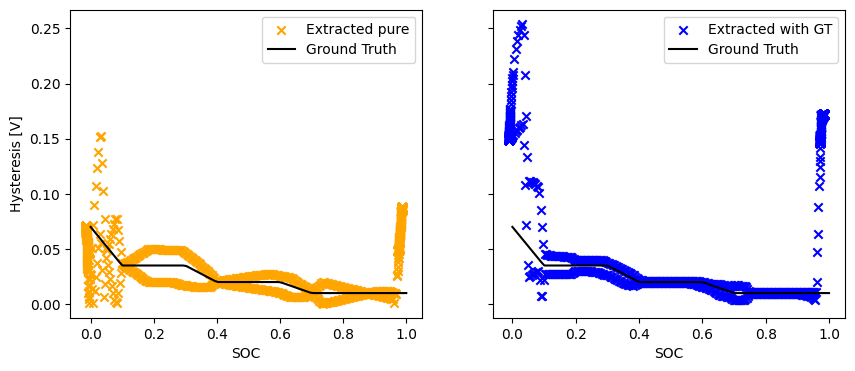

In [21]:
fig, axes = plt.subplots(1, 2, sharey='row', figsize=((10, 4)))
axes[0].set_xlabel('SOC')
axes[1].set_xlabel('SOC')
axes[0].set_ylabel('Hysteresis [V]')

# Pure extraction
axes[0].scatter(h0_extracted['soc_level'], abs(h0_extracted['value']),
                marker='x', color='orange',
                zorder=0,
                label='Extracted pure')

# Extraction with GT knowledge
axes[1].scatter(gt_h0_extracted['soc_level'], abs(gt_h0_extracted['value']),
                marker='x', color='blue',
                zorder=0,
                label='Extracted with GT')

# GT
for ax in axes:
    ax.plot(soc_plot, hyst_gt.get_value(soc=soc_plot).flatten(),
            color='k', zorder=1,
            label='Ground Truth')
    ax.legend()

Both forms of extraction struggle at the SOC extremes. This is likely caused by the high sensitivity of OCV to SOC: small numerical imprecisions in `moirae`'s Coulomb counting and explicit Euler stepper give rise to large errors in these regions.

However, note that, for the majority of the SOC domain, namely, from 10 to 95%, the hysteresis values extracted with knowledge of the ground truth parameters far outperform the "pure" extraction. This happens in part due to assumptions made in "pure" extraction case: the OCV extracted already accounts for some of these hysteresis values. That is why we observe the formation of two "bands" centered around the ground truth hysteresis, one coming from discharge, and the other, for charge.

Despite these shortcomings, it is still possible to get a decent estimate of the hysteresis from this by carefully choosing SOC knots and employing an interpolation-based regressor. It is also a good idea to include a point below and one above the SOC domain to capture the noisy extremes separately.

In [26]:
from moirae.estimators.offline.assemblers.ecm import HysteresisAssembler

# Prepare regressor
# hyst_regressor = SOCRegressor(style='lsq', parameters={'k': 0})
# hyst_regressor = SOCRegressor(style='smooth', parameters={'lam': 1.0e-04})
hyst_regressor = SOCRegressor(style='interpolate', parameters={'k': 0})

# Assembler
hyst_assembler = HysteresisAssembler(regressor=hyst_regressor,
                                     soc_points=np.array([-0.02, 0.1, 0.4, 0.7, 0.95, 1.01]))

hyst_assembled = hyst_assembler.assemble(extracted_parameter=h0_extracted)

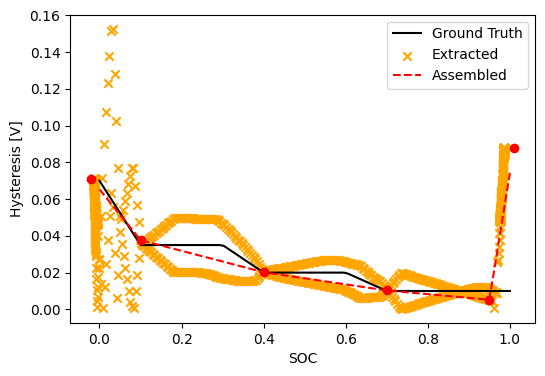

In [27]:
fig, axes = plt.subplots(figsize=(6, 4))
axes.set_xlabel('SOC')
axes.set_ylabel('Hysteresis [V]')
axes.plot(soc_plot, hyst_gt.get_value(soc=soc_plot).flatten(),
          color='k', zorder=1,
          label='Ground Truth')
axes.scatter(h0_extracted['soc_level'], abs(h0_extracted['value']),
             marker='x', color='orange', zorder=0,
             label='Extracted')
axes.plot(soc_plot, hyst_assembled.get_value(soc=soc_plot).flatten(),
          color='red', linestyle='--', zorder=2,
          label='Assembled')
axes.scatter(hyst_assembled.soc_pinpoints.flatten(), hyst_assembled.base_values.flatten(),
             color='red', marker='o')
_ = axes.legend()

### All-In-One

Alternatively, we could obtain a fully assembled and optimized aSOH directly from the RPT, using a pre-prepared Offline Estimation framework.

Note, however, that, in order to do that, the user must provide the assemblers to be used. While `moirae` will use default assemblers, they do not work out-of-the-box for the majority of cases, as different cells and different diagnostic protocols usually have their own specificities. However, "under-the-hood", the framework does exactly the steps above, but in a more automated fashion. <mark> Therefore, it is expected that the user has at least evaluated some of the extractions and adequately chosen desireable assembler before invoking these capabilities!</mark>

One advantage is that we can use the offline estimator to perform an optimization procedure over user-specified selected aSOH parameters. This procedure minimizes the mean squared error of the voltage preditions over the RPT cycles. Here, since we already looked at the extracted values (as expected) and the assemblers, we know a minimimzation is not necessary, even though the hysteresis could be better.

<mark> Note: the optimization takes a long time; in this example, trying to optimize over `ocv.ocv_ref.base_values` and over `h0.base_values` with relatively lax tolerance takes nearly 30 minutes!</mark>

In [28]:
from moirae.estimators.offline.frameworks.ecm.RPT import ECMOfflineEstimatorFromRPT

# Initialize the estimator (for demonstration purposes, use the default parameters for capacity and HPPC checkers)
offline_estimator = ECMOfflineEstimatorFromRPT()

# Estimate asoh
transient_estimated, asoh_estimated, refinement_results = offline_estimator.estimate(
    data=simulated_dataset,
    capacity_check_cycle_number=1,
    hppc_test_cycle_number=2,
    number_rc_pairs=2,
    start_soc=raw_data['SOC'].iloc[0],
    asoh_assemblers={'r0': r0_assembler,
                     'ocv': ocv_assembler,
                     'rc': rc_assemblers,
                     'hyst': hyst_assembler
                     },
    params_to_refine=[], # Do not refine; alternatively, use i.e. `['ocv.ocv_ref.base_values', 'h0.base_values']`
    minimizer_kwargs={'method': 'Nelder-Mead',
                      'options': dict(maxiter=200, fatol=1.0e-01)
                      }
    )

Let's now visualize some of these results.

In [29]:
if refinement_results is not None:
    print(refinement_results)

In [30]:
print('Capacity:')
print(f'\t Ground truth = {asoh_gt.q_t.amp_hour.item()} Amp-hour')
print(f'\t Estimated = {asoh_estimated.q_t.amp_hour.item():.2f} Amp-hour')
print('=' * 50)
print('Coulombic Efficiency:')
print(f'\t Ground truth = {(asoh_gt.ce.item() * 100):.3f}%')
print(f'\t Estimated = {asoh_estimated.ce.item() * 100:.3f}%')

Capacity:
	 Ground truth = 10 Amp-hour
	 Estimated = 9.94 Amp-hour
Coulombic Efficiency:
	 Ground truth = 99.800%
	 Estimated = 99.790%


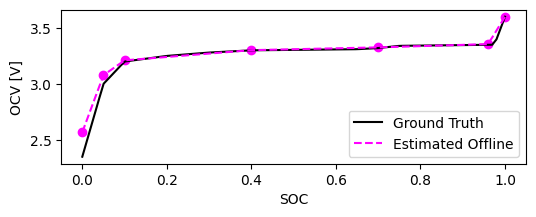

In [31]:
fig, axes = plt.subplots(figsize=(6,2))
axes.set_xlabel('SOC')
axes.set_ylabel('OCV [V]')
axes.plot(soc_plot, asoh_gt.ocv(soc_plot).flatten(),
          color='k',
          label='Ground Truth')
axes.plot(soc_plot, asoh_estimated.ocv(soc_plot).flatten(),
          '--', color='magenta',
          label='Estimated Offline')
axes.scatter(asoh_estimated.ocv.ocv_ref.soc_pinpoints.flatten(), asoh_estimated.ocv.ocv_ref.base_values.flatten(),
             marker='o', color='magenta')
_ = axes.legend()

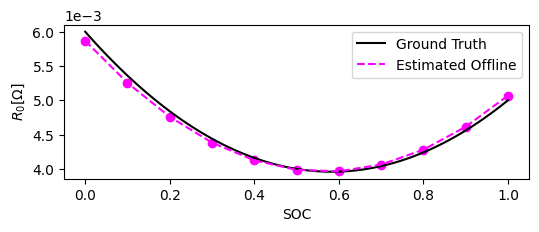

In [32]:
fig, axes = plt.subplots(figsize=(6,2))
axes.set_xlabel('SOC')
axes.set_ylabel(r'$R_0 [\Omega]$')
axes.ticklabel_format(axis='y', scilimits=(0, 0))
axes.plot(soc_plot, asoh_gt.r0.get_value(soc_plot).flatten(),
          color='k',
          label='Ground Truth')
axes.plot(soc_plot, asoh_estimated.r0.get_value(soc_plot).flatten(),
          '--', color='magenta',
          label='Estimated Offline')
axes.scatter(asoh_estimated.r0.soc_pinpoints.flatten(), asoh_estimated.r0.base_values.flatten(),
             marker='o', color='magenta')
_ = axes.legend()

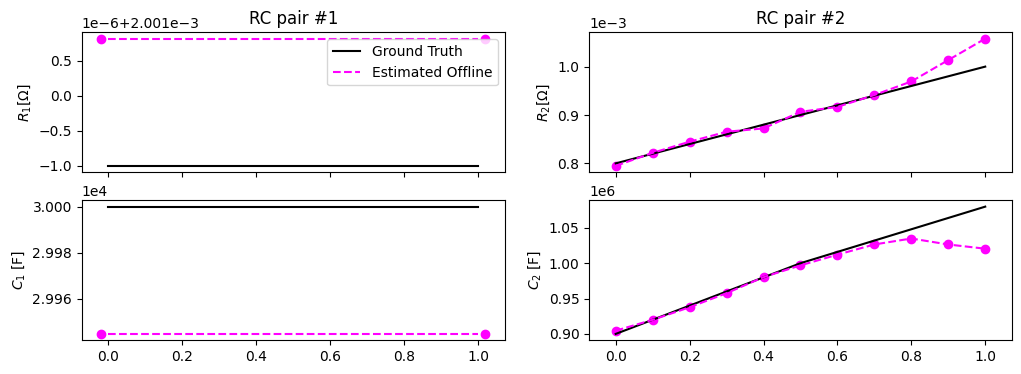

In [33]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(12, 4))

for ax in axes.flatten():
    ax.ticklabel_format(axis='y', scilimits=(0, 0))

for i, (rc_gt, rc_est) in enumerate(zip(asoh_gt.rc_elements, asoh_estimated.rc_elements)):
    axes[0, i].set_title(f'RC pair #{i+1}')

    # Resistance
    axes[0, i].set_ylabel(fr'$R_{i+1} [\Omega]$')
    axes[0, i].plot(soc_plot, rc_gt.r.get_value(soc_plot).flatten(),
                    color='k', label='Ground Truth')
    axes[0, i].plot(soc_plot, rc_est.r.get_value(soc_plot).flatten(),
                    color='magenta', linestyle='--',
                    label='Estimated Offline')
    axes[0, i].scatter(rc_est.r.soc_pinpoints.flatten(), rc_est.r.base_values.flatten(),
                       marker='o', color='magenta')

    # Capacitance
    axes[1, i].set_ylabel(fr'$C_{i+1}$ [F]')
    axes[1, i].plot(soc_plot, rc_gt.c.get_value(soc_plot).flatten(),
                    color='k', label='Ground Truth')
    axes[1, i].plot(soc_plot, rc_est.c.get_value(soc_plot).flatten(),
                    color='magenta', linestyle='--',
                    label='Estimated Offline')
    axes[1, i].scatter(rc_est.c.soc_pinpoints.flatten(), rc_est.c.base_values.flatten(),
                       marker='o', color='magenta')

_ = axes[0, 0].legend()

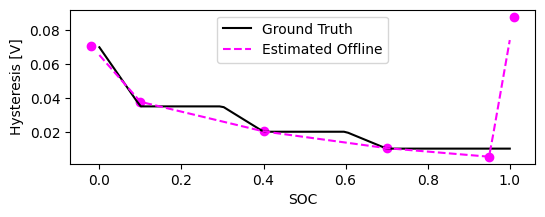

In [34]:
fig, axes = plt.subplots(figsize=(6, 2))
axes.set_xlabel('SOC')
axes.set_ylabel('Hysteresis [V]')
axes.plot(soc_plot, hyst_gt.get_value(soc_plot).flatten(),
          color='k',
          label='Ground Truth')
axes.plot(soc_plot, asoh_estimated.h0.get_value(soc_plot).flatten(),
          color='magenta', linestyle='--',
          label='Estimated Offline')
axes.scatter(asoh_estimated.h0.soc_pinpoints.flatten(), asoh_estimated.h0.base_values.flatten(),
             color='magenta', marker='o')
_ = axes.legend()

#### Simulation

Now, let's use these results to simulate the RPT data and see how the voltage profile matches.

In [35]:
from moirae.interface import run_model
from moirae.models.ecm import EquivalentCircuitModel as ECM
from moirae.estimators.offline.DataCheckers.utils import ensure_battery_dataset

# Gather RTP data
rpt_data = raw_data[raw_data['cycle_number'] <= 2]

simulation_results = run_model(model=ECM(),
                               dataset=ensure_battery_dataset(rpt_data),
                               asoh=asoh_estimated,
                               state_0=transient_estimated)

MAE = 75.2 mV
RMSE = 137.2 mV


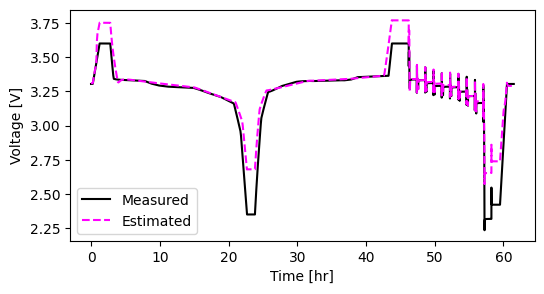

In [36]:
fig, axes = plt.subplots(figsize=(6,3))
axes.set_xlabel('Time [hr]')
axes.set_ylabel('Voltage [V]')
axes.plot(rpt_data['test_time'] / 3600, rpt_data['voltage'],
          color='k',
          label='Measured')
axes.plot(rpt_data['test_time'] / 3600, simulation_results['terminal_voltage'],
          linestyle='--', color='magenta',
          label='Estimated'
          )
_ = axes.legend()

# Compute error metrics
errs = rpt_data['voltage'] - simulation_results['terminal_voltage']
mae = np.mean(abs(errs))
rmse = np.sqrt(np.mean(np.pow(errs, 2)))
print(f'MAE = {1000*mae:.1f} mV')
print(f'RMSE = {1000*rmse:.1f} mV')

## Online Estimation

Using the estimated aSOH from the previous section, we can initialize an online estimator, which will help us keep track of the cell's state as it is used, without need for sophisticated (and long) diagnostic tests.